# Introduction

Our project is based on data from [Sussex-Huawei Locomotion Challenge ](http://www.shl-dataset.org/).\
It is a contest in which participants try to predict one of eight locomotion modes (Still, Walk, Run, Bike, Car, Bus, Train, Subway) based on readings from various sensors, such as accelerometer or gyroscope.\
We tackled our own modification of the task: we wanted to compare state-of-the-art [IndRNN](https://openaccess.thecvf.com/content_cvpr_2018/papers/Li_Independently_Recurrent_Neural_CVPR_2018_paper.pdf) model of one of the winners with approach in which we classified time series based on their plots with [Siamese CNN](https://arxiv.org/pdf/2102.04179.pdf). \
We wanted to check whether these models are able to generalise for different users when trained on data coming mainly form just one user.

# Data analysis

Below we can see plots of data from three sensors: accelerometer, gyroscope and magnetometer in one of the dimensions for various classes.
We can notice that differences in readings from different sensors for one sample are pretty similar. Additionaly, differences between classes are visible, esspecially in scale (running looks similiar to walking, but peaks are more frequent and higher), but it would probably be difficult for human to classify them (samples below are a bit cherry-picked to make more sense).

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.fft import fft
from PIL import Image

In [ ]:
acc_x = np.load("acc_data_sample.npy")
gyr_x = np.load("gyr_data_sample.npy")
mag_x = np.load("mag_data_sample.npy")
labels = np.load("label_sample.npy")[:, 0] 

In [ ]:
classes = [[] for i in range(8)]
for i in range(len(labels)):
    classes[int(labels[i]) - 1].append(i)

## Accelerometer

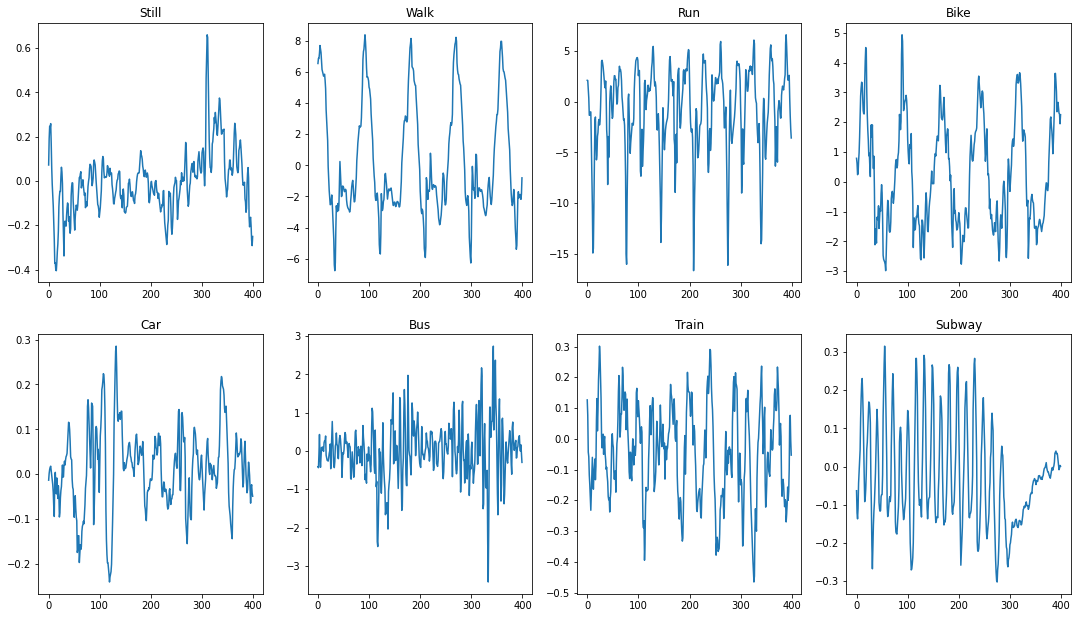

In [ ]:
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(18.5, 10.5)
label_names = ["Still", "Walk", "Run", "Bike", "Car", "Bus", "Train", "Subway"]
for i in range(2):
    for j in range(4):        
        axs[i, j].plot(acc_x[classes[i * 4 + j][4]])
        axs[i, j].set_title(label_names[i * 4 + j])

## Gyroscope

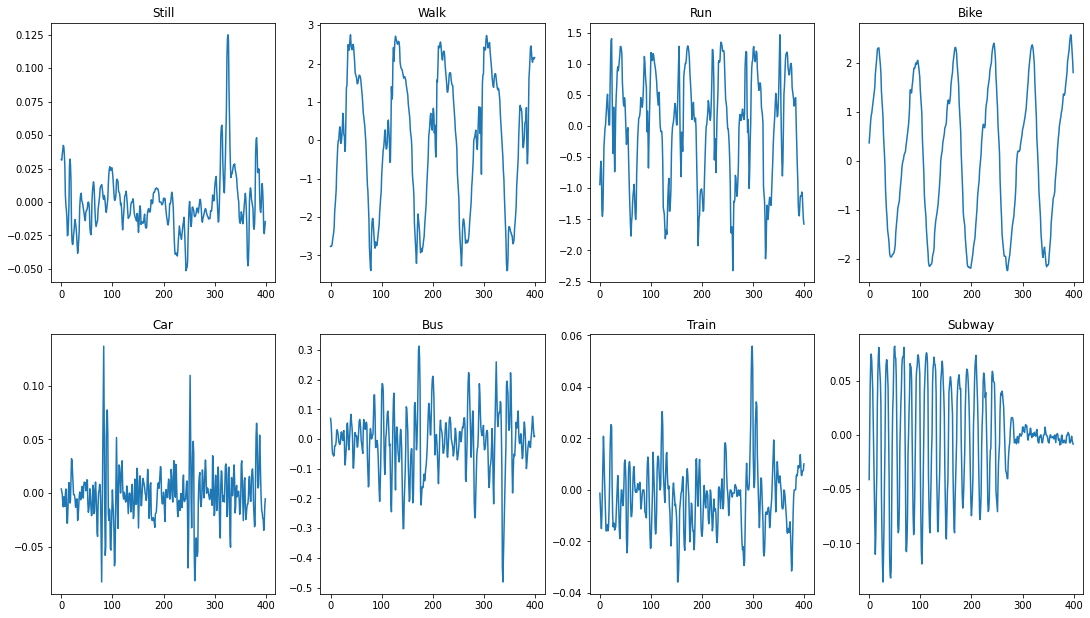

In [ ]:
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(18.5, 10.5)
label_names = ["Still", "Walk", "Run", "Bike", "Car", "Bus", "Train", "Subway"]
for i in range(2):
    for j in range(4):        
        axs[i, j].plot(gyr_x[classes[i * 4 + j][4]])
        axs[i, j].set_title(label_names[i * 4 + j])

## Magnetometer

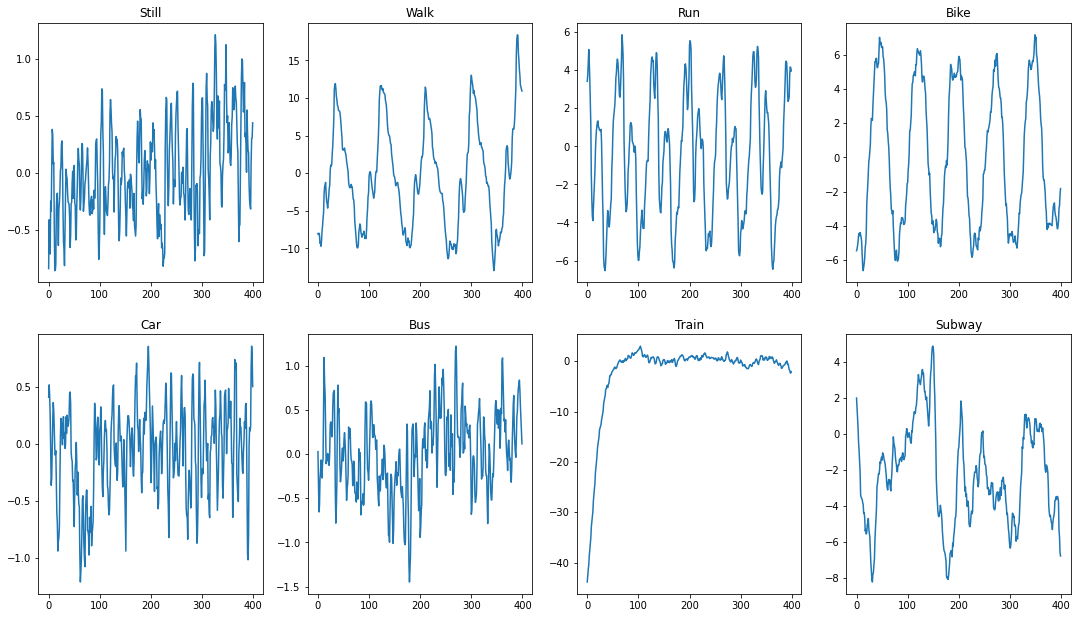

In [ ]:
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(18.5, 10.5)
label_names = ["Still", "Walk", "Run", "Bike", "Car", "Bus", "Train", "Subway"]
for i in range(2):
    for j in range(4):        
        axs[i, j].plot(mag_x[classes[i * 4 + j][4]])
        axs[i, j].set_title(label_names[i * 4 + j])

# Data preprocessing

Our data needed a lot of preprocessing. \
Important part was a lot of downsampling, which was required to be able to train the models on our hardware in sensible time.\
Moreover, we applied NED (North East Down) transformation, changing coordinate system, as suggested in papers from Challenge. \ 
Additionaly, preprocessing specific for models was carried out and is demonstrated below. 


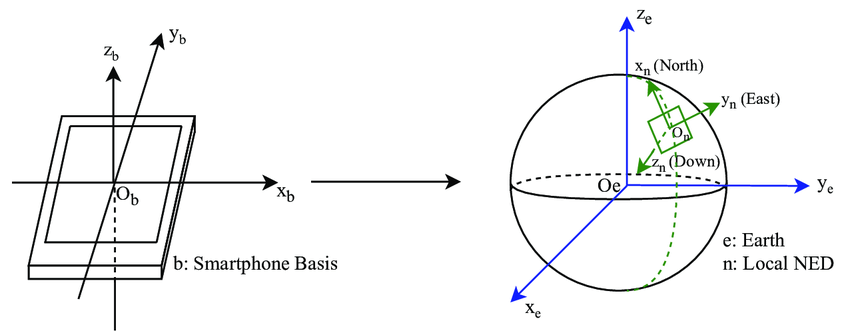

## For RNN models

For RNN models (LSTM and IndRNN) we are using around 80k of samples for training, 1/3 is from user #2 and #3, the rest is from user #1. \
Validation and testing set consists of samples only from user #2 and #3. \
Data from each sample is partitioned into sliding windows. For each window we carry out FFT and use the spectrum and it mean and standard variance as input (after concatenating data from each sensor) for the model.


In [ ]:
def prepare_windows(sample):
    windows = np.zeros((sample.shape[0], 16, 100))
    for file_idx in range(sample.shape[0]):
        for i in range(16):
            windows[file_idx, i, :] = sample[file_idx][i*20:100+i*20]
    return windows
    
def fft_features(window):
    yf = np.fft.fft(window)[:len(window)//2 + 1]
    mean = np.mean(yf)
    std_var = np.std(yf)
    return np.append(yf, [mean, std_var])

In [ ]:
acc_windows = prepare_windows(acc_x[0][np.newaxis, ...])
acc_fft = fft_features(acc_windows[0, 0])

Plot of raw data from accelerometer.

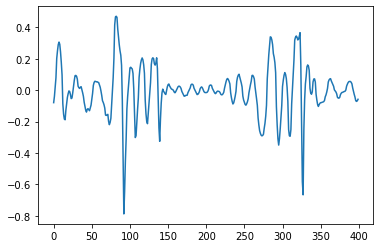

In [ ]:
plt.plot(acc_x[0])

Plot of the first of sliding windows.

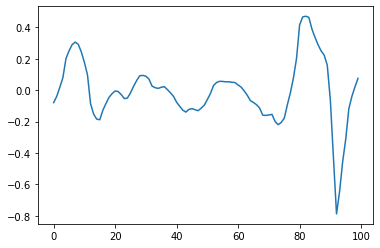

In [ ]:
plt.plot(acc_windows[0, 0])

Plot of real part of FFT of the window.

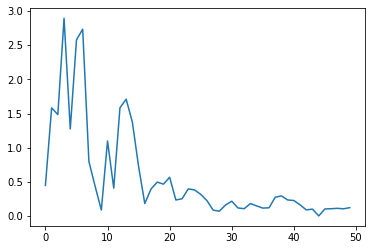

In [ ]:
plt.plot(np.abs(np.real(acc_fft[:50])))

## For CNN model

For CNN model we are using similiar data distribution as for RNN models (train mostly on user #1 with addition of user #2 and #3, test on user #2 and #3), but amount of data is reduced 6-7 times. \
This is because for CNN we use images of plots of readings from sensors. For them to be readable they have much bigger size than raw data (100x100 vs 500).
To prepare the images we plot the data, normalize it to binary as suggested in paper and rescale them as shown below.\
We want the scale on axises to be visible - authors of the paper claim that it allows the model to differentiate between similar plots but with different values.

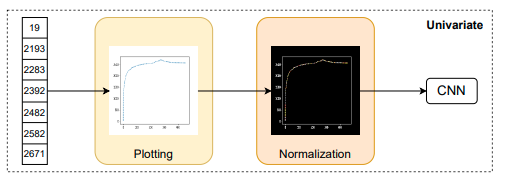

In [ ]:
def to_img(sample):
    
    def fig2img(fig):
        """Convert a Matplotlib figure to a PIL Image and return it"""
        import io
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        img = Image.open(buf)
        return img
    plt.figure(figsize=(2.5, 2.5))
    plt.plot(sample)
    fig = plt.gcf()
    img = fig2img(fig)
    pixels = np.asarray(img)
    pixels = pixels.astype('float32')
    pixels /= 255.0
    pixels = pixels[:, :, 0]
    pixels = 1 - pixels
    pixels[pixels > 0] = 1
    plt.clf()
    plt.cla()
    plt.close()
    return pixels

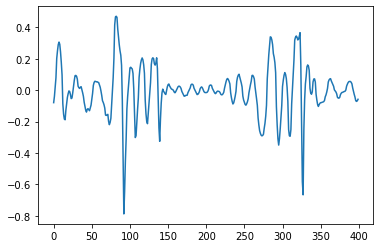

In [ ]:
plt.plot(acc_x[0])

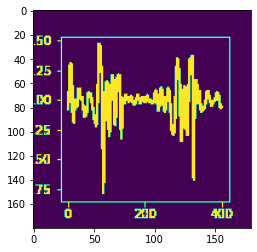

In [ ]:
plt.imshow(to_img(acc_x[0]))

# Models & results

We used three models:
*   LSTM as absolute baseline and for testing whether our data finally fits into the RAM and CUDA
*   [IndRNN](https://openaccess.thecvf.com/content_cvpr_2018/papers/Li_Independently_Recurrent_Neural_CVPR_2018_paper.pdf) as architecture known to be highly successful
*   [Siamese CNN](https://arxiv.org/pdf/2102.04179.pdf)




## LSTM

Simple LSTM model with 5 layers and dropout.

**Validation accuracy**

Best value of validation accuracy was around 62%. After 50 epochs model started overfitting.

**Train confusion matrix**

Accuracy for trainset for the parameters with the highest validation accuracy was around 80%. Model sometimes had problems with differentiating between car, bus, train and subway, which is understandable. Another source of problems is missclasifying staying still and in bus.

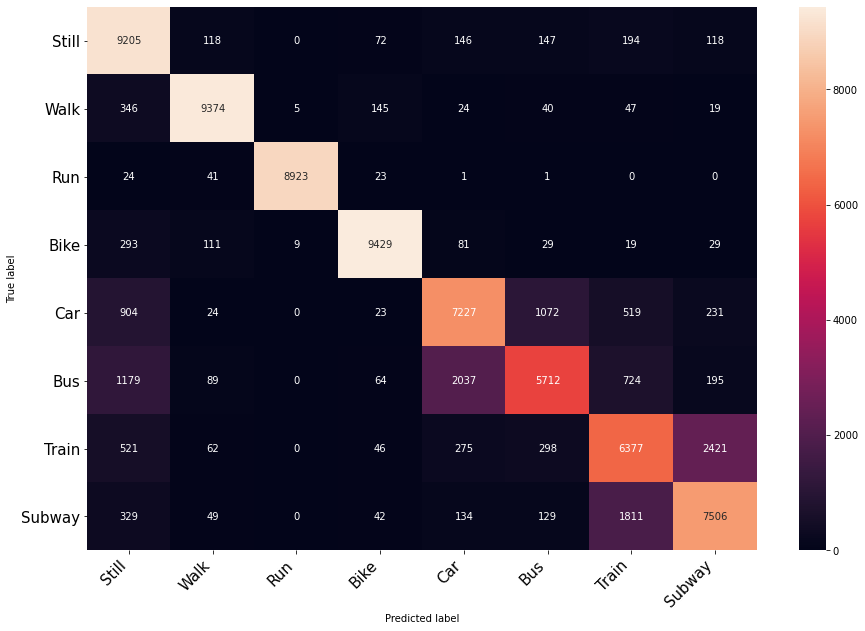

**Test confusion matrix**

Test accuracy was around 61%. We can see that majority of errors come from missclassifying car, bus, train and subway, but also staying still and being in the bus. 

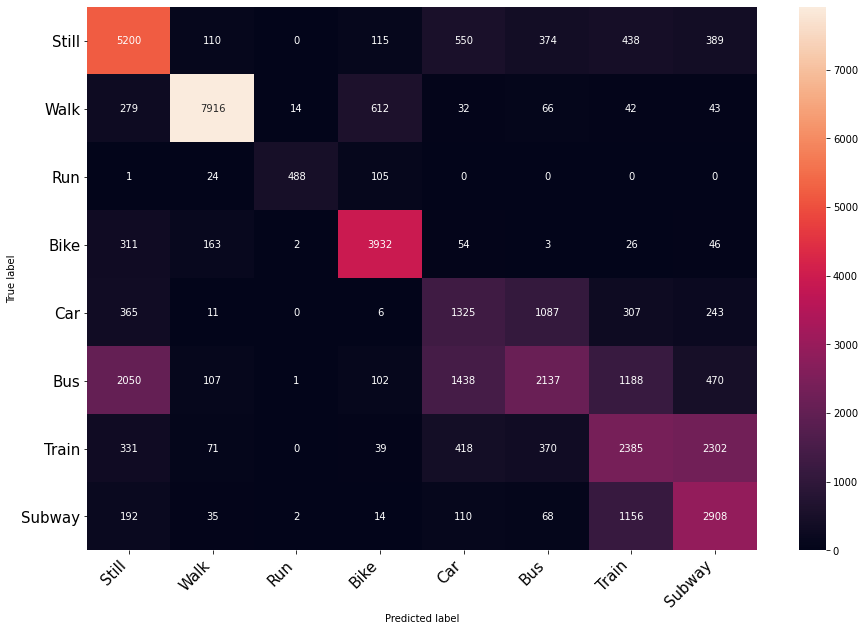

## IndRNN

IndRNN based on source code of [official implementation](https://github.com/Sunnydreamrain/IndRNN_pytorch). It differs from standard RNN mainly because it uses Hadamard product instead of matrix multiplication while computing hidden states and ReLU as activation. It causes neurons in the same layer to be independent, resulting in much easier to control gradient computations. More details can be found [here](https://openaccess.thecvf.com/content_cvpr_2018/papers/Li_Independently_Recurrent_Neural_CVPR_2018_paper.pdf). \
 We used 5 layers with parameters inspired by the authors' suggestions, but scaled down to accomodate for our hardware. 

**Validation accuracy**

Best value of validation accuracy was around 69%. IndRNN was the only model which did not overfit even after 1000 epochs.

**Train confusion matrix**

Accuracy for trainset for the parameters with the highest validation accuracy was around 83%. Errors IndRNN make are similar to those made by LSTM both on test and train datasets. 

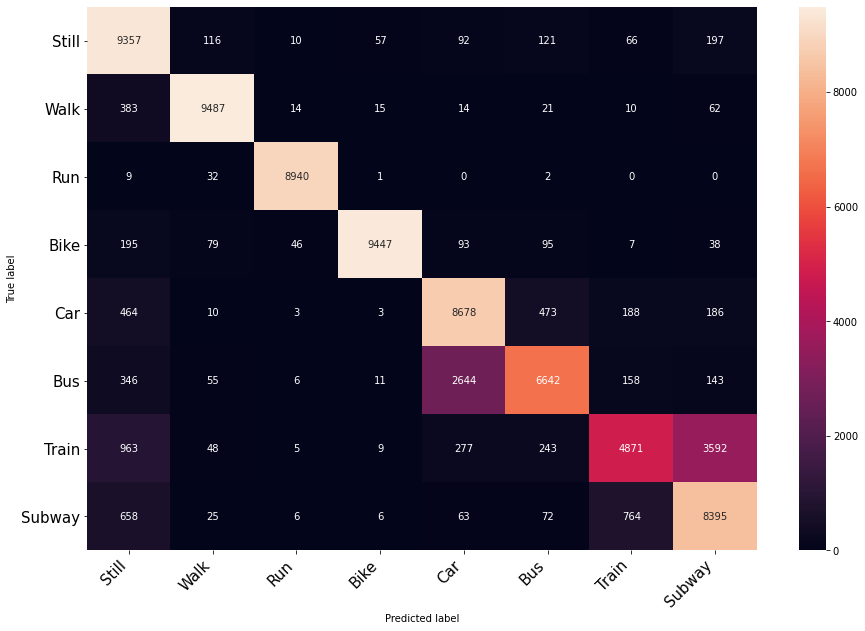

**Test confusion matrix**

Test accuracy was around 68%.

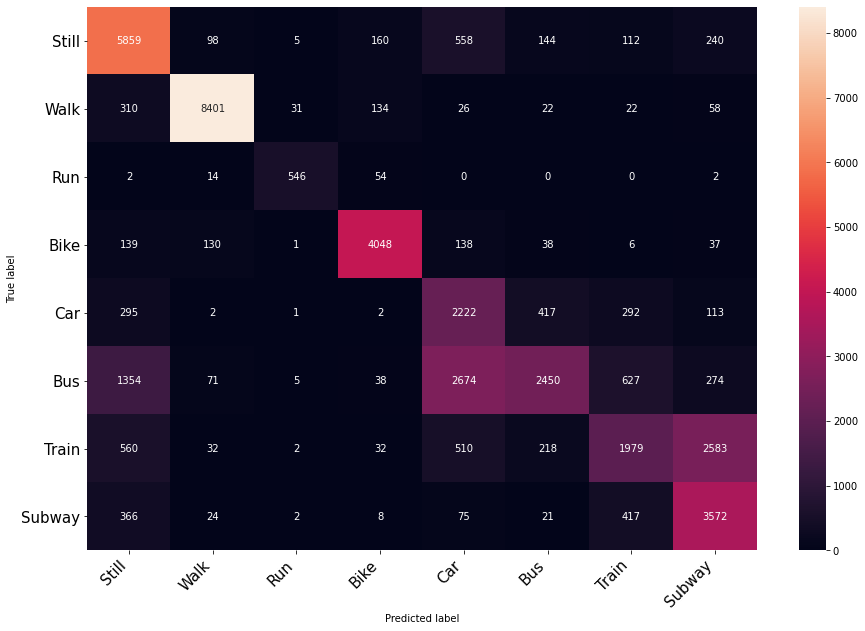

## Siamese CNN

Siamese CNN model consists of convolutional part, aggregator and linear classifier part. \
For one sample, we feed the model with images of plots of data from few sensors. Each of the image is passed through identical (weights and architecture) convolutional part. The output is then concatenated and passed thorough linear classifier (so here each sensor is processed with different weights). \
We used pretty standard convolutional architecture and added dropout between linear layers.

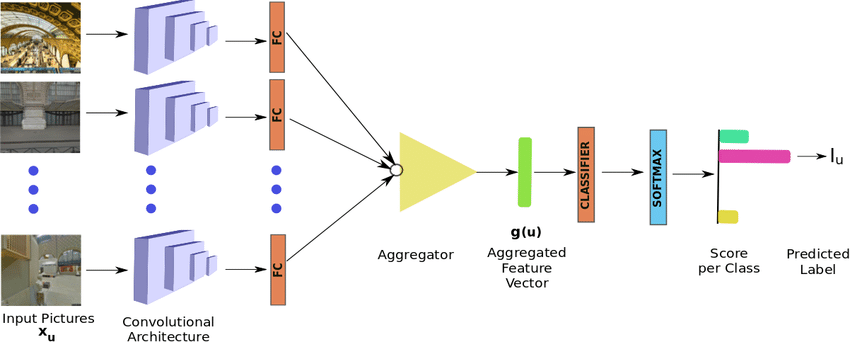

**Validation accuracy**

Best value of validation accuracy was around 65% - higher than for LSTM and not that far from IndRNN result. \
Similar to LSTM, model started overfitting (around 100 epoch).
It proves that this approach can be pretty successful, but it causes problems of huge data size and tedious training.

**Train confusion matrix**

Interesting outcome is that this model performed best on validation set when it was fitting training data almost perfectly - with 99% accuracy. It may mean that with small amount of data we are using, all of it needs to be learned by the model just to be able to notice how it can spot differences between images. It may also prove that with bigger amount of data this model would be able to noticeably increase its accuracy. 

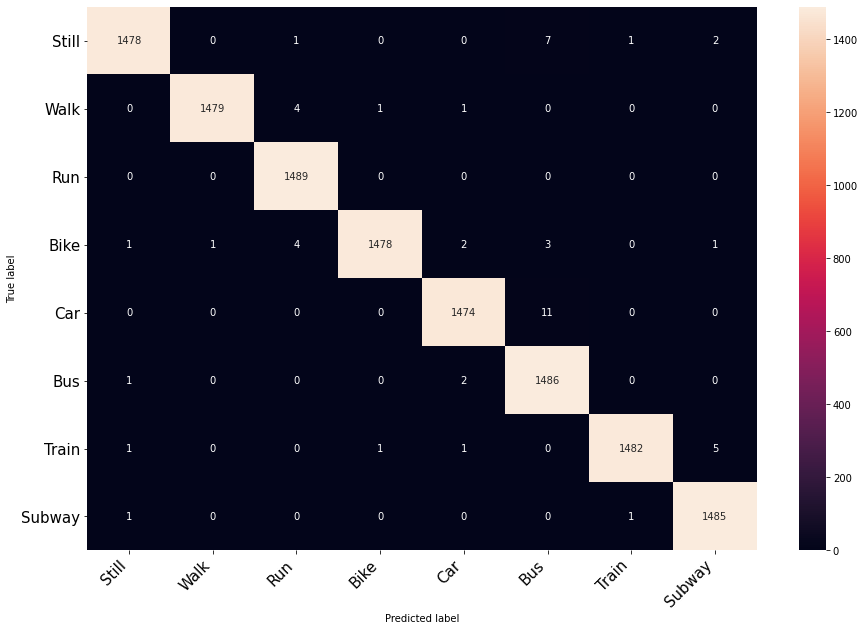

**Test confusion matrix**

Test accuracy for this model is around 64%.

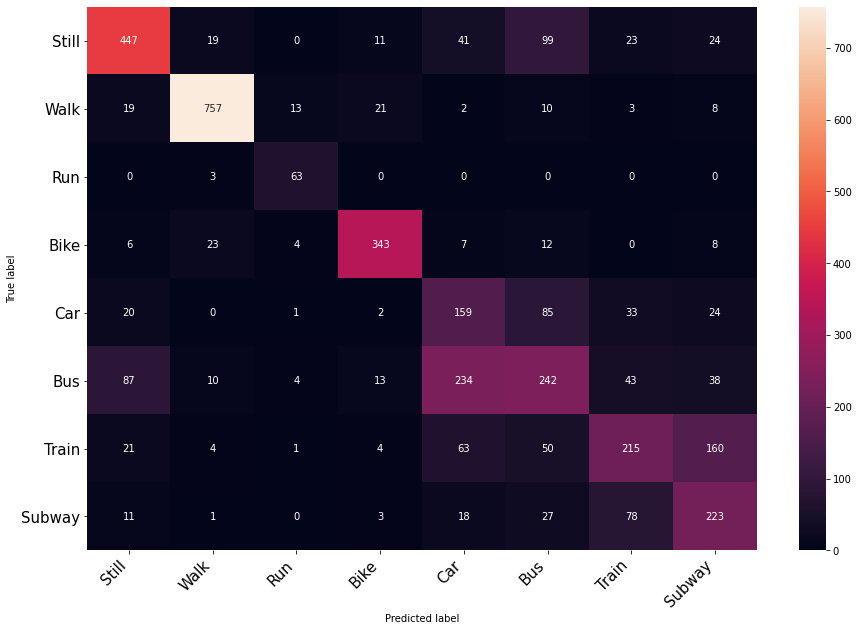

# Conclusion

To summarize: IndRNN had highest (69%) accuracy as expected, but CNN (64%) was able to beat LSTM (61%) model. It is important to note that CNN was trained on 6-7 times less samples than rest of the models because of hardware limitations. In the future it would be interesting to check how much of improvement we can get when using more data for CNN approachment. We could also try more difficult versions of the challenge and test more advanced IndRNN models, but to do so we would need much more computing power :) 
